In [1]:
import json
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
import sqlite3
import nltk
import spacy
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import umap
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,log_loss, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

%matplotlib inline

from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy

/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/robholmstrom/miniconda3/lib/python3.7/site-packages

The restaurant business in the US is huge. It comprises about 4% of the US GDP, where 99% of restaurants are family-owned. This industry currently employs~ 15 million people, or about 10% of the working population, and is projected to continue to grow by double digits over the next ten years. However, failure rate of restaurants is 60% within the first year and 80% failure rate with 5 years. The most common reason for failure is due to suboptimal location. My project will build a model that predicts restaurant success at the metroplex level based popularity of current restaurant categories (food type, and venue type, and ethnicity). This model will be of value to potential restauranteurs and banks to inform whether a planned business will be successful in a chosen location. 

Restaurant popularity index will generated from a yelp review dataset that includes restaurant reviews from 7 metroplexes. NLP techniques be used to 1) create food category features by vectorization and 2) generate popularity index label in order to train the model. I will evaluate multiple supervised models (logistic regression, random forest, gradient boost and support vector machines), as well as deep learning models with tensorflow keras packages. Unsupervised learning can be used on vectorized language data to uncover review subtypes in order to help construct popularity labels. 

The first challenges are to deal with data size. There are millions of reviews and decisions will need to be made to reduce the number of instances used. Other major hurdles will be in engineering the popularity label. Ideally it would be nice to have a clean success rate label, but that data would take a very long to time to achieve, as restaurant open and closure rates are not easy to find at this scale. The star rating is not always the best way to evaluate the success of a business as it may be biased, inaccurate or even ridiculous. Finally, the number of positive and negative reviews overall may be unbalanced. Therefore, upsampling or downsampling may be used to overcome these issues where necessary.


<img src="images/yelp_overview.png" width="800" height="400">

The data set for this analysis can be downloaded here. The zip file opens up into multiple sub-files. For this project, the "review" and "business" data were the only ones used. https://www.yelp.com/dataset


<img src="images/US_map_image.png" width="800" height="400">

A map is shown for the locations for cities included in the analysis. It is important to note that the states are used as the labels but are really referring to a major metroplex in that state. Review numbers for each metroplex centers are shown as points and colored by surrounding cities in that metroplex.

# Data  cleaning and EDA

In [137]:
# Load in raw business data 
df_business = pd.read_json("/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/yelp_academic_dataset_business.json", lines = True)

In [314]:
# The business dataset includes details about the business but not about reviews for that business
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


In [144]:
# Select for businesses that have at least 10 reviews in order to 1) reduce the number or reviews
# 2) increase statistical power of average review per business. Also limit to reviews from businesses that are open.
df_bus_select =  df_business.loc[(df_business['review_count']>10) & (df_business['is_open']==1)]

In [313]:
df_bus_select['state'].value_counts()

AZ    25856
NV    18278
ON    11579
NC     6131
OH     5439
PA     4307
QC     3021
AB     2032
WI     1971
IL      719
SC      449
NY        9
CA        9
TX        3
CO        2
MB        1
VA        1
GA        1
MI        1
WA        1
NE        1
HI        1
FL        1
Name: state, dtype: int64

In [145]:
# Set a threshold for how many cities will be analyzed by number of reviews given for the whole metroplex.
# This will avoid class imbalance for city selection modeling by removing cities that are well underrepresented here
threshold = 0.1
review_by_state = pd.DataFrame(df_bus_select['state'].value_counts())
states_select = review_by_state[review_by_state['state'] > threshold*review_by_state.max()['state']]
states_select
# Following states will be chosen for further analysis

,state
AZ,25856
NV,18278
ON,11579
NC,6131
OH,5439
PA,4307
QC,3021


In [140]:
# Load in review data
df_reviews = pd.read_json('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/yelp_academic_dataset_review.json', lines = True)

In [160]:
# Create a year column to investigate reviews by year
df_reviews['year'] = df_reviews.date.dt.year

In [161]:
# Review data set includes the individual review info but not detailed information about the business
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
 9   year         int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 612.0+ MB


In [162]:
review_by_year = df_reviews.date.dt.year.value_counts()

Text(0, 0.5, 'Yelp Reviews (millions)')

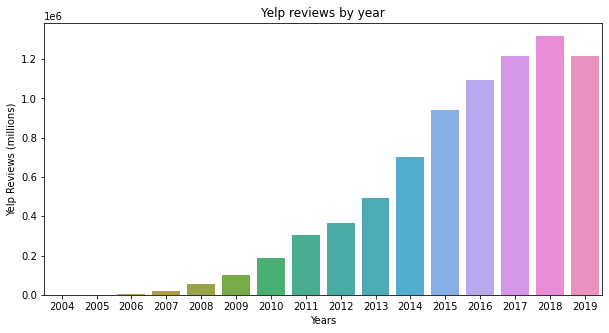

In [163]:
# Plot number of reviews by year
plt.figure(figsize=(10, 5))
sns.barplot(review_by_year.index,review_by_year.values).set_title('Yelp reviews by year')
plt.xlabel('Years')
plt.ylabel('Yelp Reviews (millions)')

The graph above shows the increasing number of reviews that are given for business since Yelp began. Since the reviews number per year seem to be plateaued at 2016, this will be chosen as the cut off to refine the number of reviews to be included further as well as exclude business that may have been more biased to get reviews earlier on. Therefore the last four years include a more comprehensive distribution of business that are reviewed

In [164]:
# Limit review dataset to last four years
df_reviews_4yrs = df_reviews[df_reviews['year'].isin([2016, 2017, 2018, 2019])]


In [165]:
# Merge the business dataset with the review dataset
df_rev_bus_raw = df_reviews_4yrs.merge(df_bus_select, on = 'business_id', how= 'inner')

In [168]:
# Rename the individual review column as 'stars' to differentiate it from the average reviews for each business
df_rev_bus_raw = df_rev_bus_raw.rename(columns = {'stars_x': 'stars'})

In [13]:
# Narrow the dataset for just the states mentioned earlier with sufficient review instances
df_rev_bus_select = df_rev_bus_raw.loc[df_rev_bus_raw['state'].isin(states_select.index)==True]

In [315]:
# Select for restaurant businesses
df_food_rev = df_rev_bus_select[df_rev_bus_select['categories'].str.contains('Restaurant')|
                 df_rev_bus_select['categories'].str.contains('Coffee & Tea')]

In [401]:
df_rev_bus_raw.isnull().sum()

review_id            0
user_id              0
business_id          0
stars                0
useful               0
funny                0
cool                 0
text                 0
date                 0
year                 0
name                 0
address              0
city                 0
state                0
postal_code          0
latitude             0
longitude            0
stars_y              0
review_count         0
is_open              0
attributes       76045
categories         189
hours           160641
text length          0
dtype: int64

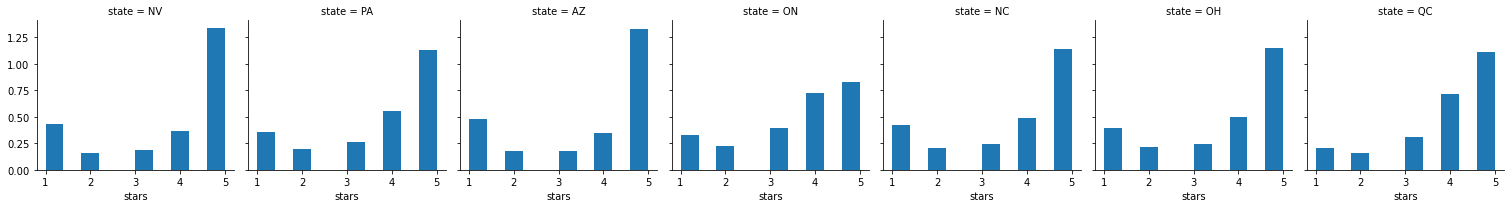

In [417]:
# The overall star rating distribution for restaurants by city
df_rev_bus_raw['text length'] = df_rev_bus_raw['text'].apply(len)
g = sns.FacetGrid(data=df_rev_bus_select, col='state')
g.map(plt.hist, 'stars', density=True, rwidth = 2)


Star distribution across states are fairly similar

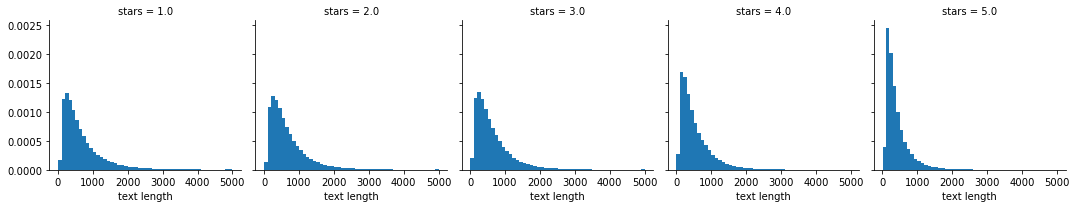

In [419]:
# The overall star rating distribution by text length.
df_rev_bus_raw['text length'] = df_rev_bus_raw['text'].apply(len)
g = sns.FacetGrid(data=df_rev_bus_select, col='stars')
g.map(plt.hist, 'text length', bins = 50, density=True, rwidth = 2)

Text length is higher for positively scored restaurants. People write more about something when they REALLY like

# Feature Engineering and EDA

## Cherry picked 'food type' words from Yelp's general restaurant category associated list 
Acai Bowls, Bagels, Bakeries, BeerWine&Spirits, Bubble Tea, Chimney Cakes, Cupcakes, Custom Cakes, Desserts, Donuts, Empanadas, Gelato, Honey, Ice Cream & Frozen Yogurt, Imported Food, Juice Bars & Smoothies, Kombucha, Meaderies, Piadina, Poke, Pretzels, Shaved Ice, Shaved Snow, Fruits & Veggies, Herbs & Spices, Macarons, Olive Oil, Breakfast & Brunch, Pancakes, Buffets, Burgers, Cheesesteaks, Chicken Wings, Dim Sum,
Comfort Food,
Creperies,
Fast Food,
Fish & Chips,
Fondue,
Game Meat,
Hot Dogs,
Hot Pot,
Conveyor Belt Sushi,
Izakaya,
Japanese Curry,
Ramen,
Teppanyaki,
Kebab,
Kosher,
Live/Raw Food,
Falafel,
Tacos,
Noodles,
Pan Asia,
Pizza,
Polish,
Polynesian,
Poutineries,
Salad,
Sandwiches,
Seafood,
Soul Food,
Soup,
Southern,
Tapas/Small Plates,
Vegan,
Vegetarian,
Waffles,
Wraps


In [324]:

Food_types = 'Acai Bowls, Bagels, Bakeries, BeerWine&Spirits, Bubble Tea, Chimney Cakes, Cupcakes, Custom Cakes, Desserts, Donuts, Empanadas, Gelato, Honey, Ice Cream & Frozen Yogurt, Imported Food, Juice Bars & Smoothies, Kombucha, Meaderies, Piadina, Poke, Pretzels, Shaved Ice, Shaved Snow, Fruits & Veggies, Herbs & Spices, Macarons, Olive Oil, Breakfast & Brunch, Pancakes, Buffets, Burgers, Cheesesteaks, Chicken Wings, Dim Sum, Comfort Food, Creperies, Fast Food, Fish & Chips, Fondue, Game Meat, Hot Dogs, Hot Pot, Conveyor Belt Sushi, Izakaya, Japanese Curry, Ramen, Teppanyaki, Kebab, Kosher, Live/Raw Food, Falafel, Tacos, Noodles, Pan Asia, Pizza, Polish, Polynesian, Poutineries, Salad, Sandwiches, Seafood, Soul Food, Soup, Southern, Tapas/Small Plates, Vegan, Vegetarian, Waffles, Wraps'.split(',')

## Cherry picked 'ethnicity' words from Yelp's general restaurant category associated list 

Afghan,
African,
Senegalese,
South African,
American (New),
American (Traditional),
Arabian,
Argentine,
Armenian,
Asian Fusion,
Australian,
Austrian,
Bangladeshi,
Barbeque,
Basque,
Belgian,
Brasseries,
Brazilian,
British,
Bulgarian,
Burmese,
Cajun/Creole,
Cambodian,
Caribbean,
Dominican,
Haitian,
Puerto Rican,
Trinidadian,
Catalan,
Chinese,
Cantonese,
Hainan,
Shanghainese,
Szechuan,
Cuban,
Czech,
Eritrean,
Ethiopian,
Filipino,
French,
Mauritius,
Georgian,
German,
Greek,
Guamanian,
Hawaiian,
Himalayan/Nepalese,
Honduran,
Hungarian,
Iberian,
Indian,
Indonesian,
Irish,
Italian,
Calabrian,
Sardinian,
Sicilian,
Tuscan,
Japanese,
Korean,
Laotian,
Latin American,
Colombian,
Salvadoran,
Venezuelan,
Malaysian,
Mediterranean,
Mexican,
Middle Eastern






















































































































































In [330]:
Ethnicity = 'Afghan, African, Senegalese, South African, American (New), American (Traditional), Arabian, Argentine, Armenian, Asian Fusion, Australian, Austrian, Bangladeshi, Barbeque, Basque, Belgian, Brasseries, Brazilian, British, Bulgarian, Burmese, Cajun/Creole, Cambodian, Caribbean, Dominican, Haitian, Puerto Rican, Trinidadian, Catalan, Chinese, Cantonese, Hainan, Shanghainese, Szechuan, Cuban, Czech, Eritrean, Ethiopian, Filipino, French, Mauritius, Georgian, German, Greek, Guamanian, Hawaiian, Himalayan/Nepalese, Honduran, Hungarian, Iberian, Indian, Indonesian, Irish, Italian, Calabrian, Sardinian, Sicilian, Tuscan, Japanese, Korean, Laotian, Latin American, Colombian, Salvadoran, Venezuelan, Malaysian, Mediterranean, Mexican, Middle Eastern'.split(',')

## Cherry picked venue words from Yelp's general restaurant category associated list 

Beverage Store,
Breweries,
Brewpubs,
Butcher,
CSA,
Cideries,
Coffee & Tea,
Coffee Roasteries,
Convenience Stores,
Distilleries,
Do-It-Yourself Food,
Farmers Market,
Food Delivery Services,
Food Trucks,
Grocery,
International Grocery,
Internet Cafes,
Organic Stores,
Patisserie/Cake Shop,
Smokehouse,
Specialty Food,
Candy Stores,
Cheese Shops,
Chocolatiers & Shops,
Health Markets,
Meat Shops,
Pasta Shops,
Popcorn Shops,
Seafood Markets,
Street Vendors,
Tea Rooms,
Water Stores,
Wineries,
Wine Tasting Room,
Cafes,
Themed Cafes,
Cafeteria,
Chicken Shop,
Delis,
Diners,
Dinner Theater,
Food Court,
Food Stands,
Reunion,
Gastropubs,
Hong Kong Style Cafe,
Pop-Up Restaurants,
Steakhouses,
Supper Clubs,
Sushi Bars,
Tapas Bars




































































































In [335]:
Venue_type = 'Beverage Store, Breweries, Brewpubs, Butcher, CSA, Cideries, Coffee & Tea, Coffee Roasteries, Convenience Stores, Distilleries, Do-It-Yourself Food, Farmers Market, Food Delivery Services, Food Trucks, Grocery, International Grocery, Internet Cafes, Organic Stores, Patisserie/Cake Shop, Smokehouse, Specialty Food, Candy Stores, Cheese Shops, Chocolatiers & Shops, Health Markets, Meat Shops, Pasta Shops, Popcorn Shops, Seafood Markets, Street Vendors, Tea Rooms, Water Stores, Wineries, Wine Tasting Room, Cafes, Themed Cafes, Cafeteria, Chicken Shop, Delis, Diners, Dinner Theater, Food Court, Food Stands, Reunion, Gastropubs, Hong Kong Style Cafe, Pop-Up Restaurants, Steakhouses, Supper Clubs, Sushi Bars, Tapas Bars'.split(',')

In [336]:
# Create cleaned series for food category types to allow selection from the category words in the df_food dataframe
food_types = pd.Series(Food_types).dropna().str.strip().str.replace(' ', '')
ethnicities = pd.Series(Ethnicity).dropna().str.strip().str.replace(' ', '')
venue_types = pd.Series(Venue_type).dropna().str.strip().str.replace(' ', '')

In [338]:
# Strip category list of any extra white spaces
df_food = df_food_rev.copy()
catlist_clean = df_food['categories'].str.replace(' ', '' ).str.replace(',', ', ')
df_food.head(4)

,Unnamed: 0_x,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,text length
0,4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,...,89074,36.035068,-115.046353,3.5,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",841
1,3103,gQuXBrYo8dqY7h_rfDzwLw,46TNf-5T5EcNFRJPYv_nrw,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,Love the chicken. It's always hot and fresh ta...,2018-01-09 20:25:20,...,89074,36.035068,-115.046353,3.5,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",222
2,3173,xkq0ekkZ39uSbb29LihkfQ,OTGWjBCELxkZ6lpS2OEtxQ,IS4cv902ykd8wj1TR0N3-A,3.0,0.0,1.0,0.0,"Great food right down the street, long line si...",2017-01-28 00:03:26,...,89074,36.035068,-115.046353,3.5,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",330
3,20520,m4AkgxXvb-GHuDK4b9i9sA,YvlcRfeulgtusMFBOQTWzw,IS4cv902ykd8wj1TR0N3-A,1.0,0.0,0.0,1.0,Terrible terrible service I waited 30 minutes ...,2017-01-15 05:55:07,...,89074,36.035068,-115.046353,3.5,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",370


In [339]:
# Add in category column that has been cleaned of white spaces
df_food['categories_filtered']= catlist_clean

In [340]:
# Create food type list corresponding to each row as this will be included as a separate column
type_list = []

for x in df_food['categories_filtered']:
    sublist = []
    for i in food_types:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        type_list.append(['Undefined'])
    else:
        type_list.append(sublist)  

print(len(type_list))
print(df_food.shape[0])


2638450
2638450


In [341]:
# Create venue list corresponding to each row as this will be included as a separate column
venue_list = []

for x in  df_food['categories_filtered']:
    sublist = []
    for i in venue_types:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        venue_list.append(['Restaurant'])
    else:
        venue_list.append(sublist)  

print(len(venue_list))
print(df_food.shape[0])


2638450
2638450


In [21]:
# Create ethnicity list corresponding to each row as this will be included as a separate column
ethnicity_list = []

for x in  df_food['categories_filtered']:
    sublist = []
    for i in ethnicities:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        ethnicity_list.append(['Undefined'])
    else:
        ethnicity_list.append(sublist)  
print(len(ethnicity_list))
print(df_food.shape[0])


2638450
2638450


In [343]:
# Insert lists as columns
df_food['food_type'] = type_list
df_food['ethnicity'] = ethnicity_list
df_food['venue'] = venue_list


In [344]:
# Include extracted words for all three subcategories back into one column and exclude any rows for which there is 
# 'Undefined' when ethnicity or food types are not specified for the restaurant
df_food['food_comb'] = (df_food['food_type']+df_food['ethnicity']+df_food['venue']).apply(lambda x: ', '.join(x))
df_food['food_comb'] = df_food['food_comb'].str.replace('Undefined,', '')


In [345]:
df_food.head(4)

,Unnamed: 0_x,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,is_open,attributes,categories,hours,text length,categories_filtered,food_type,ethnicity,venue,food_comb
0,4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,...,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",841,"FastFood, Restaurants, Sandwiches, ChickenWings","[ChickenWings, FastFood, Sandwiches]",[Undefined],[Restaurant],"ChickenWings, FastFood, Sandwiches, Restaurant"
1,3103,gQuXBrYo8dqY7h_rfDzwLw,46TNf-5T5EcNFRJPYv_nrw,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,Love the chicken. It's always hot and fresh ta...,2018-01-09 20:25:20,...,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",222,"FastFood, Restaurants, Sandwiches, ChickenWings","[ChickenWings, FastFood, Sandwiches]",[Undefined],[Restaurant],"ChickenWings, FastFood, Sandwiches, Restaurant"
2,3173,xkq0ekkZ39uSbb29LihkfQ,OTGWjBCELxkZ6lpS2OEtxQ,IS4cv902ykd8wj1TR0N3-A,3.0,0.0,1.0,0.0,"Great food right down the street, long line si...",2017-01-28 00:03:26,...,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",330,"FastFood, Restaurants, Sandwiches, ChickenWings","[ChickenWings, FastFood, Sandwiches]",[Undefined],[Restaurant],"ChickenWings, FastFood, Sandwiches, Restaurant"
3,20520,m4AkgxXvb-GHuDK4b9i9sA,YvlcRfeulgtusMFBOQTWzw,IS4cv902ykd8wj1TR0N3-A,1.0,0.0,0.0,1.0,Terrible terrible service I waited 30 minutes ...,2017-01-15 05:55:07,...,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","Fast Food, Restaurants, Sandwiches, Chicken Wings","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",370,"FastFood, Restaurants, Sandwiches, ChickenWings","[ChickenWings, FastFood, Sandwiches]",[Undefined],[Restaurant],"ChickenWings, FastFood, Sandwiches, Restaurant"


In [346]:
#Flatten the lists
df_food_clean = df_food.drop(columns = ['categories'])
df_food_clean['food_type'] = df_food_clean['food_type'].apply(lambda x: ', '.join(x))
df_food_clean['venue'] = df_food_clean['venue'].apply(lambda x: ', '.join(x))
df_food_clean['ethnicity']= df_food_clean['ethnicity'].apply(lambda x: ', '.join(x))

In [348]:
df_food_clean['postal_code'].replace('', np.nan, inplace = True)
df_food_clean.dropna(inplace = True)

In [349]:
df_food_clean.reset_index(drop=True, inplace= True)


In [407]:
df_food_clean.isnull().sum()

review_id              0
user_id                0
business_id            0
stars                  0
useful                 0
funny                  0
cool                   0
text                   0
date                   0
year                   0
Unnamed: 0_y           0
name                   0
address                0
city                   0
state                  0
postal_code            0
latitude               0
longitude              0
stars_y                0
review_count           0
is_open                0
attributes             0
hours                  0
text length            0
categories_filtered    0
food_type              0
ethnicity              0
venue                  0
food_comb              0
dtype: int64

In [350]:
df_food_clean.head(4)

,Unnamed: 0_x,review_id,user_id,business_id,stars,useful,funny,cool,text,date,...,review_count,is_open,attributes,hours,text length,categories_filtered,food_type,ethnicity,venue,food_comb
0,4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,...,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",841,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant"
1,3103,gQuXBrYo8dqY7h_rfDzwLw,46TNf-5T5EcNFRJPYv_nrw,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,Love the chicken. It's always hot and fresh ta...,2018-01-09 20:25:20,...,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",222,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant"
2,3173,xkq0ekkZ39uSbb29LihkfQ,OTGWjBCELxkZ6lpS2OEtxQ,IS4cv902ykd8wj1TR0N3-A,3.0,0.0,1.0,0.0,"Great food right down the street, long line si...",2017-01-28 00:03:26,...,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",330,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant"
3,20520,m4AkgxXvb-GHuDK4b9i9sA,YvlcRfeulgtusMFBOQTWzw,IS4cv902ykd8wj1TR0N3-A,1.0,0.0,0.0,1.0,Terrible terrible service I waited 30 minutes ...,2017-01-15 05:55:07,...,159,1,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",370,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant"


In [351]:
df_food_clean = df_food_clean.rename(columns = {'stars_x':'stars'})

In [352]:
df_food_clean.drop(['Unnamed: 0_x'], axis = True, inplace = True)

In [409]:
# Binarize reviews as Good or Bad ('yes' or 'no') that includes 1 and 2 stars bad, and 4 and 5 stars as good.
# Neutrals were left out since in a pilot study (not shown) did not help the model performance
df_food_clean['stars'].replace(3,np.nan, inplace =True)
df_food_clean.dropna(inplace=True)
df_food_clean['star_binary'] = np.where(df_food_clean['stars'] <3, 'no', 'yes')


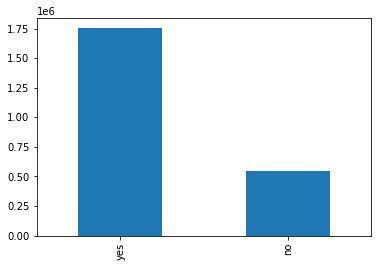

In [410]:
# Check for class imbalance in review categories
df_food_clean['star_binary'].value_counts().plot.bar()

In [411]:
# Create column with combined state and review status, in case it will by used later on
df_food_clean['state_star'] = df_food_clean['state'] + df_food_clean['star_binary']


In [78]:
df_food_v2 =df_food_clean.reset_index(drop=True)

In [79]:
df_food_v3 = df_food_v2.copy()

In [412]:
df_food_v3.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,...,attributes,hours,text length,categories_filtered,food_type,ethnicity,venue,food_comb,star_binary,state_star
0,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,2017.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",841,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",yes,NVyes
1,gQuXBrYo8dqY7h_rfDzwLw,46TNf-5T5EcNFRJPYv_nrw,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,Love the chicken. It's always hot and fresh ta...,2018-01-09 20:25:20,2018.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",222,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",yes,NVyes
2,m4AkgxXvb-GHuDK4b9i9sA,YvlcRfeulgtusMFBOQTWzw,IS4cv902ykd8wj1TR0N3-A,1.0,0.0,0.0,1.0,Terrible terrible service I waited 30 minutes ...,2017-01-15 05:55:07,2017.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",370,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",no,NVno


In [81]:
# Count vectorize words from the combined category list associated across all reviews to do some word count analysis
vectorizer = CountVectorizer(analyzer='word', min_df=200, max_features=50)
Xvec = vectorizer.fit_transform(df_food_v3['food_comb'])
bow_df = pd.DataFrame(Xvec.toarray(), columns=vectorizer.get_feature_names())

In [82]:
# Using the top 50 occuring words, with a minimum instance of 200, create table of word counts for the dataset
word_count_table = pd.concat([bow_df, df_food_v3['state']], axis = 1).set_index('state')

In [83]:
word_count_table.columns

Index(['american', 'asianfusion', 'bakeries', 'barbeque', 'breakfast',
       'brunch', 'buffets', 'burgers', 'cafes', 'chickenwings', 'chinese',
       'coffee', 'comfortfood', 'delis', 'desserts', 'diners', 'fastfood',
       'french', 'frozenyogurt', 'gastropubs', 'icecream', 'indian', 'italian',
       'japanese', 'juicebars', 'korean', 'mediterranean', 'mexican', 'new',
       'noodles', 'pizza', 'restaurant', 'salad', 'sandwiches', 'seafood',
       'smallplates', 'smoothies', 'soup', 'southern', 'specialtyfood',
       'steakhouses', 'sushibars', 'tacos', 'tapas', 'tea', 'thai',
       'traditional', 'vegan', 'vegetarian', 'vietnamese'],
      dtype='object')

In [84]:
word_count_table.groupby('state').mean()

,american,asianfusion,bakeries,barbeque,breakfast,brunch,buffets,burgers,cafes,chickenwings,...,steakhouses,sushibars,tacos,tapas,tea,thai,traditional,vegan,vegetarian,vietnamese
state,,,,,,,,,,,,,,,,,,,,,
AZ,0.389902,0.052072,0.036010,0.047468,0.197269,0.197269,0.016253,0.110699,0.061089,0.038577,...,0.046035,0.051468,0.031094,0.011694,0.112930,0.027932,0.198439,0.034279,0.044214,0.019884
NC,0.408258,0.062592,0.034514,0.060412,0.164774,0.164774,0.007417,0.098844,0.039963,0.062793,...,0.051384,0.061330,0.014828,0.032816,0.075521,0.022875,0.219995,0.019612,0.038994,0.024872
NV,0.366207,0.077740,0.034398,0.054786,0.203114,0.203114,0.049833,0.104097,0.051880,0.030407,...,0.078282,0.072522,0.018288,0.024876,0.078580,0.028885,0.185572,0.041900,0.028306,0.017324
OH,0.445273,0.032438,0.035113,0.041194,0.133366,0.133366,0.014623,0.098954,0.038743,0.033202,...,0.053318,0.040295,0.028331,0.015021,0.067774,0.025003,0.225562,0.026786,0.032948,0.011630
ON,0.100051,0.072564,0.036859,0.038343,0.105846,0.105846,0.014252,0.057912,0.068128,0.020198,...,0.029681,0.071624,0.000070,0.029149,0.097757,0.047264,0.067358,0.026855,0.030936,0.033389
PA,0.455616,0.027133,0.033079,0.028411,0.144621,0.144621,0.007122,0.085216,0.053742,0.037206,...,0.046079,0.045804,0.027304,0.008684,0.093110,0.040450,0.212882,0.026875,0.033791,0.008830
QC,0.085385,0.030652,0.050421,0.034192,0.179686,0.179686,0.004764,0.079208,0.120611,0.004880,...,0.040922,0.033026,0.000321,0.026310,0.101833,0.014860,0.042292,0.040791,0.037310,0.023368


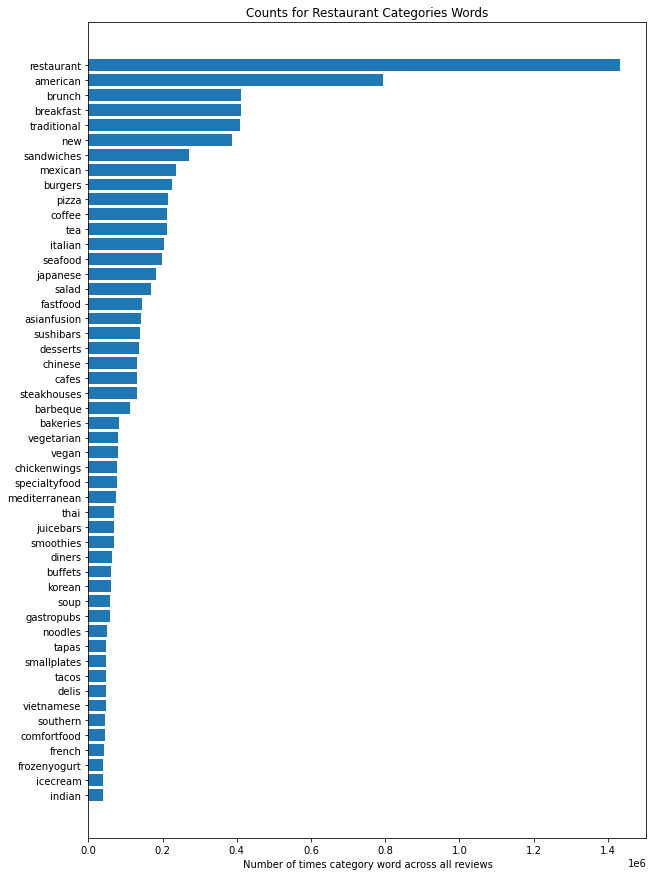

In [169]:
# Visualize word counts for dataset that will be used as features for making model
plt.figure(figsize = (10, 15))
plt.barh(y = pd.DataFrame(word_count_table.groupby('state').sum().sum().sort_values(ascending = True)).index, width = pd.DataFrame(word_count_table.groupby('state').sum().sum().sort_values(ascending = True))[0])
plt.xlabel('Number of times category word across all reviews')
plt.title('Counts for Restaurant Categories Words')
plt.show()

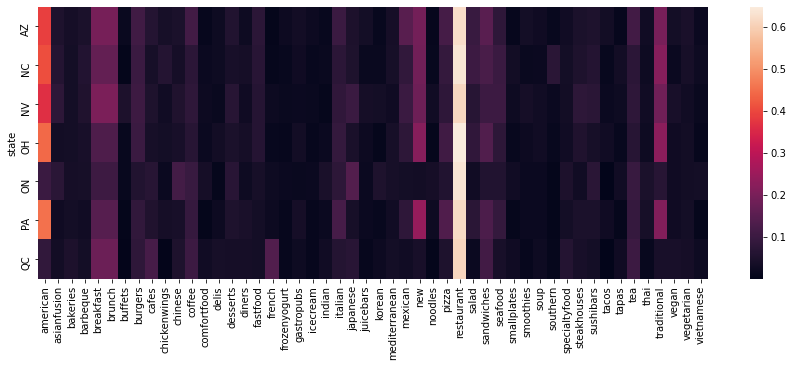

In [86]:
# Word Count analysis by city
plt.figure(figsize = (15,5))
sns.heatmap(word_count_table.groupby('state').mean())

From the heatmap above, it looks like some category words are associated differently between Canada and US, like 'French', which maps to Montreal and 'American', which is completely absent from Canadian categories. Also, Toronto seem to have enrichment in Chinese and Japanese restaurants.

<img src="images/model.png" width="800" height="400">

In [212]:
# TF-IDF vectorize words from the combined category list associated across all reviews 
vectorizertf = TfidfVectorizer(analyzer='word', min_df=50, max_features=50)
Xvectf = vectorizertf.fit_transform(df_food_v3['food_comb'])
tf_df = pd.DataFrame(Xvectf.toarray(), columns=vectorizertf.get_feature_names())

In [215]:
df_vec = tf_df

In [216]:
# Label X as features (the vectorized word columns) and y as the label (binary review rating--Good or Bad)
X = df_vec
y = df_food_v3['star_binary']

In [421]:
# Check if vectorized words form interesting clusters by PCA
pca = PCA()
Xpca = pca.fit_transform(X)


In [420]:
df_food_clean

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,...,attributes,hours,text length,categories_filtered,food_type,ethnicity,venue,food_comb,star_binary,state_star
0,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,2017.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",841,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",yes,NVyes
1,gQuXBrYo8dqY7h_rfDzwLw,46TNf-5T5EcNFRJPYv_nrw,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,Love the chicken. It's always hot and fresh ta...,2018-01-09 20:25:20,2018.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",222,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",yes,NVyes
3,m4AkgxXvb-GHuDK4b9i9sA,YvlcRfeulgtusMFBOQTWzw,IS4cv902ykd8wj1TR0N3-A,1.0,0.0,0.0,1.0,Terrible terrible service I waited 30 minutes ...,2017-01-15 05:55:07,2017.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",370,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",no,NVno
5,tXIj_C8U4beIx78VFRYX7w,BDmxm7aeWFOLT35gSvkmig,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,0.0,New location right down the road from home. Al...,2017-03-27 07:17:46,2017.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",180,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",yes,NVyes
6,BsMAYfPC0QmAo-cGUBAPBg,uP7zEIagg-ORBkbRQADsiQ,IS4cv902ykd8wj1TR0N3-A,4.0,0.0,0.0,1.0,Perfectly simple menu! The chicken was not oil...,2017-08-08 05:20:18,2017.0,...,"{'DriveThru': 'True', 'GoodForMeal': ""{'desser...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",136,"FastFood, Restaurants, Sandwiches, ChickenWings","ChickenWings, FastFood, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Sandwiches, Restaurant",yes,NVyes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569382,zgdS5ggJ4D6Eers3VyXaQQ,8MYvRl2qr3Ys6URmLSLJDw,KzNG3-kfGCC01USMS2BZvA,4.0,0.0,1.0,0.0,Great wings! Food is good staff is friendly an...,2017-07-02 00:39:31,2017.0,...,"{'BusinessAcceptsCreditCards': 'True', 'Caters...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",73,"Restaurants, Pizza",Pizza,Undefined,Restaurant,"Pizza, Restaurant",yes,PAyes
2569383,BoACFPqsa_wLvG61ZYJqTg,RuxZ18eNzPRU2rpVvzYGkA,KzNG3-kfGCC01USMS2BZvA,1.0,2.0,0.0,0.0,"Wings were good, delivery drivers with Nazi ta...",2018-08-07 13:41:56,2018.0,...,"{'BusinessAcceptsCreditCards': 'True', 'Caters...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",136,"Restaurants, Pizza",Pizza,Undefined,Restaurant,"Pizza, Restaurant",no,PAno
2569384,KWV3NOmZgnqmfns-bG1PVA,7K0kU03q2kWGD4I1ZsMznA,KzNG3-kfGCC01USMS2BZvA,5.0,1.0,0.0,0.0,Love the wings from the West Mifflin location....,2016-09-30 00:29:32,2016.0,...,"{'BusinessAcceptsCreditCards': 'True', 'Caters...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",166,"Restaurants, Pizza",Pizza,Undefined,Restaurant,"Pizza, Restaurant",yes,PAyes
2569385,MKNsjnas-oh64zx0LhcopQ,HtuReE1QJa2Catuq4Z0z9g,KzNG3-kfGCC01USMS2BZvA,5.0,0.0,1.0,1.0,"Best wing sauces in the city, great subs fresh...",2016-07-21 22:47:06,2016.0,...,"{'BusinessAcceptsCreditCards': 'True', 'Caters...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",168,"Restaurants, Pizza",Pizza,Undefined,Restaurant,"Pizza, Restaurant",yes,PAyes


Text(0.5, 1.0, 'PCA of word vector features across all reviews')

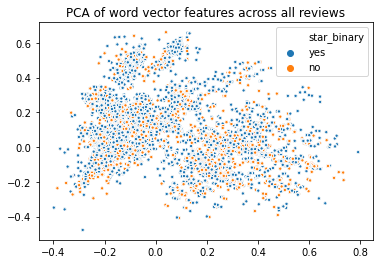

In [426]:
sns.scatterplot(Xpca[:, 0], Xpca[:, 1], hue = df_food_clean['star_binary'], s= 10)
plt.title('PCA of word vector features across all reviews')

PCA above does show some mild clustering but does not seem to correspond with review ratings

In [218]:
# Encode the review categories as numeric values for modeling
le_train = LabelEncoder()
y_le = le_train.fit_transform(y)

In [219]:
# Make a dictionary that will revert the data eventually back to strings later on for plot labeling--will 
# become clearer when looking at plots. Also allows handling of multiclass cases where reversion from encoded
# numbers back to original string labels is help for plot labeling.
y_state_dict= pd.concat([pd.DataFrame(y_le), pd.DataFrame(y)], axis = 1).groupby('star_binary')[0].mean()

In [220]:
y_state_dict_swap = {value:key for key, value in y_state_dict.items()}


In [221]:
# Train data
X_train, X_test, y_train, y_test = train_test_split(X, y_le, stratify = y_le, random_state = 42)

In [354]:
pd.Series(y_test).value_counts()

1    437834
0    136471
dtype: int64

In [222]:
# Down sample the data so that 'yes' and 'no' class are balanced--have quite a few instances so shouldn't be a big
# loss information. Upsampling was taking way too long
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)
X_test_rus, y_test_rus = rus.fit_sample(X_test, y_test)


In [224]:
# Scale the train and test feature separately
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_rus)
X_test_scaled = scaler.transform(X_test_rus)

# Supervised Learning models using review score as label


## Logistic Regression

In [225]:
# The parameters set here were established from a grid search in an earlier pilot study
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class= 'ovr', solver = 'lbfgs', penalty = 'l2', max_iter = 1000)
lr.fit(X_train_scaled, y_train_rus)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [226]:
# create lr predictions
y_test_pred = lr.predict(X_test_scaled)
y_train_pred = lr.predict(X_train_scaled)

In [227]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="grey" if cm[i, j] > thresh else "black", fontsize=20)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="grey" if cm[i, j] > thresh else "black",fontsize=20)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [228]:

print('LR1 confusion matrix')
#lr1train = confusion_matrix(y_train, y_pred_train, normalize= None)
lr1test = confusion_matrix(y_test_rus, y_test_pred, normalize = None)
test = pd.DataFrame(lr1test).rename(columns = y_state_dict_swap, index = y_state_dict_swap)

LR1 confusion matrix


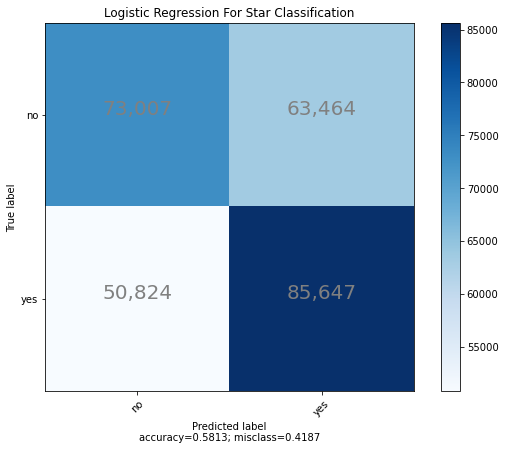

In [232]:
labels = list(y_state_dict_swap.values())
target_names = labels 
plot_confusion_matrix(lr1test,
                          target_names,
                          title='Logistic Regression For Star Classification',
                          cmap=None,
                          normalize=None)

In [229]:
# Macro average score is prefered scoring method here to prioritize against misclassification over missing a class

print('Test macro average recall score is ',recall_score(y_test_rus, y_test_pred, average = 'macro'))
print('Train macro average recall score is ',recall_score(y_train_rus, y_train_pred, average = 'macro'))

Test macro average recall score is  0.5812736771914913
Train macro average recall score is  0.5810526290078722


In [368]:
recall_score(y_test_rus, y_test_pred, average = 'macro')

In [233]:
# Calculated how many fold better is prediction over random guess
recall_score(y_test_rus, y_test_pred, average = 'macro')/(1/lr1test.shape[0])

1.1625473543829825

In [389]:
LRscore = 100*(recall_score(y_test_rus, y_test_pred, average = 'macro')/(1/lr1test.shape[0])-1)

Logistic Regression does not perform that great. Only a little better than a coin toss:

In [230]:
print('Test accuracy score is ',accuracy_score(y_test_rus, y_test_pred))
print('Train accuracy score is ',accuracy_score(y_train_rus, y_train_pred))

Test accuracy score is  0.5812736771914913
Train accuracy score is  0.5810526290078722


## Random Forest

In [234]:
# Initial hypertuning was tested where reduction of depth gave more consistency, but with low bias.
rf = RandomForestClassifier(max_depth = 8)
rf.fit(X_train_scaled, y_train_rus)
y_test_predrf = rf.predict(X_test_scaled)
y_train_predrf = rf.predict(X_train_scaled)



In [236]:
rftest = confusion_matrix(y_test_rus, y_test_predrf, normalize = None)
dfrf = pd.DataFrame(rftest).rename(columns = y_state_dict_swap)

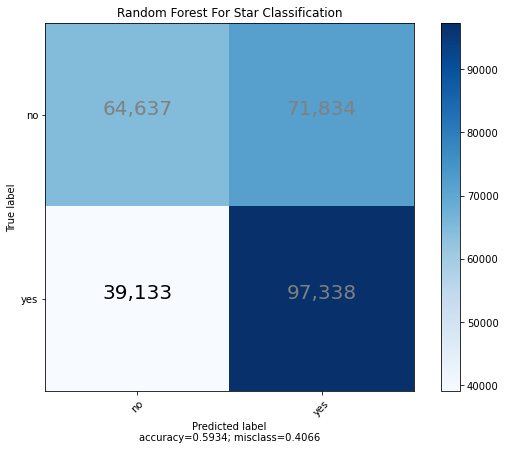

In [237]:
matrix_labels  = list(y_state_dict_swap.values())
target_names = matrix_labels 
plot_confusion_matrix(rftest,
                          target_names,
                          title='Random Forest For Star Classification',
                          cmap=None,
                          normalize=None)

In [235]:
print('Test macro average recall score is ',recall_score(y_test_rus, y_test_predrf,average = 'macro'))
print('Train macro average recall score is ',recall_score(y_train_rus, y_train_predrf,average = 'macro'))

Test macro average recall score is  0.5934410973759993
Train macro average recall score is  0.593073497910423


In [369]:
recall_score(y_test_rus, y_test_predrf,average = 'macro')

In [238]:
# Calculated how many fold better is prediction over random guess

recall_score(y_test_rus, y_test_predrf, average = 'macro')/(1/rftest.shape[0])

1.1868821947519985

In [380]:
RFscore = 100*(recall_score(y_test_rus, y_test_predrf, average = 'macro')/(1/rftest.shape[0])-1)

Random Forsest does not perform that great either. Still only a little better than a coin toss:

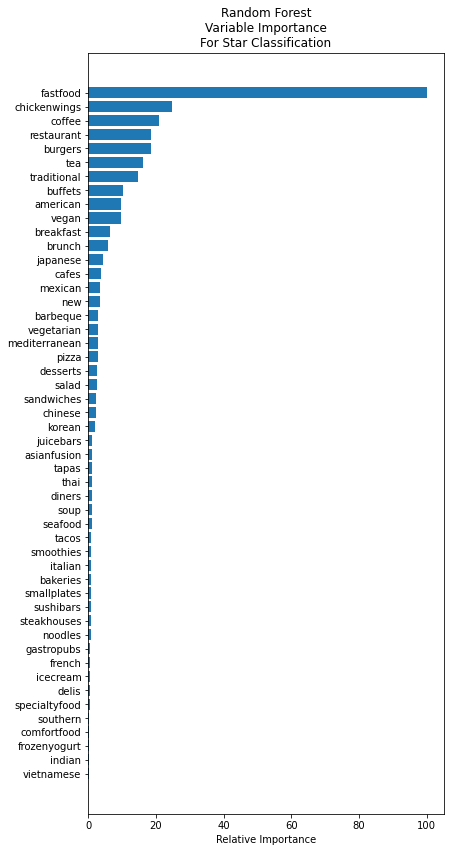

In [239]:
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize = (14,14))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest\nVariable Importance\nFor Star Classification')
plt.show()

# Gradient Boosting

In [240]:

params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance', 
          'learning_rate':0.08, 
          'subsample':.62, 
          'min_samples_split':.02}

# Initialize and fit the model.
gbc = GradientBoostingClassifier(**params)
gbc.fit(X_train_scaled, y_train_rus)

y_test_predgb = gbc.predict(X_test_scaled)
y_train_predgb = gbc.predict(X_train_scaled)

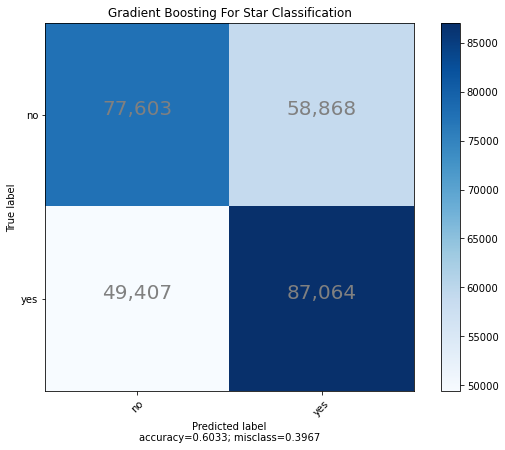

In [241]:
gbtest = confusion_matrix(y_test_rus, y_test_predgb)
plot_confusion_matrix(gbtest,target_names,'Gradient Boosting For Star Classification')

In [243]:
print('Test macro average recall score is ',recall_score(y_test_rus, y_test_predgb,average = 'macro'))
print('Train macro average recall score is ',recall_score(y_train_rus, y_train_predgb,average = 'macro'))

Test macro average recall score is  0.6033039986517281
Train macro average recall score is  0.604583879847489


In [370]:
recall_score(y_test_rus, y_test_predgb,average = 'macro')

In [242]:
# Calculated how many fold better is prediction over random guess. 
recall_score(y_test_rus, y_test_predgb, average = 'macro')/(1/gbtest.shape[0])

1.2066079973034562

In [381]:
GBscore = 100*(recall_score(y_test_rus, y_test_predgb, average = 'macro')/(1/gbtest.shape[0])-1)

Gradient Boosting does not perform that great either. Still only a little better than a coin toss:

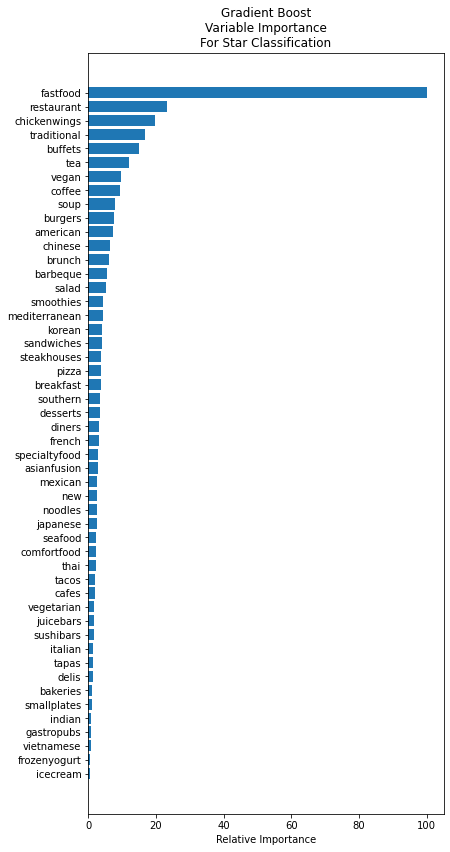

In [244]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize = (14,14))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boost\nVariable Importance\nFor Star Classification')
plt.show()

## Neural Networks

In [246]:
# Initialize model for binary classification
model = Sequential()
model.add(Dense(128, input_dim= X_train_scaled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [247]:
# 10 epochs were sufficient to max out score
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = [Recall()])
model.fit(X_train_scaled, y_train_rus, batch_size=200, epochs=10, validation_data = (X_test_scaled, y_test_rus))

Train on 818826 samples, validate on 272942 samples
Epoch 1/10
818826/818826 [==============================] - 9s 11us/sample - loss: 0.6571 - recall_1: 0.6462 - val_loss: 0.6534 - val_recall_1: 0.6204
Epoch 2/10
818826/818826 [==============================] - 8s 9us/sample - loss: 0.6501 - recall_1: 0.6348 - val_loss: 0.6501 - val_recall_1: 0.5740
Epoch 3/10
818826/818826 [==============================] - 7s 9us/sample - loss: 0.6475 - recall_1: 0.6322 - val_loss: 0.6487 - val_recall_1: 0.5971
Epoch 4/10
818826/818826 [==============================] - 7s 9us/sample - loss: 0.6460 - recall_1: 0.6308 - val_loss: 0.6467 - val_recall_1: 0.6341
Epoch 5/10
818826/818826 [==============================] - 7s 9us/sample - loss: 0.6449 - recall_1: 0.6303 - val_loss: 0.6461 - val_recall_1: 0.6293
Epoch 6/10
818826/818826 [==============================] - 7s 9us/sample - loss: 0.6441 - recall_1: 0.6289 - val_loss: 0.6459 - val_recall_1: 0.6361
Epoch 7/10
818826/818826 [=====================

In [266]:
y_predNN = model.predict_classes(X_test_scaled)


0.6172593444761159


In [267]:
NNtest = confusion_matrix(y_test_rus, y_predNN, normalize = None)



In [269]:
matrix_labels = list(y_state_dict_swap.values())

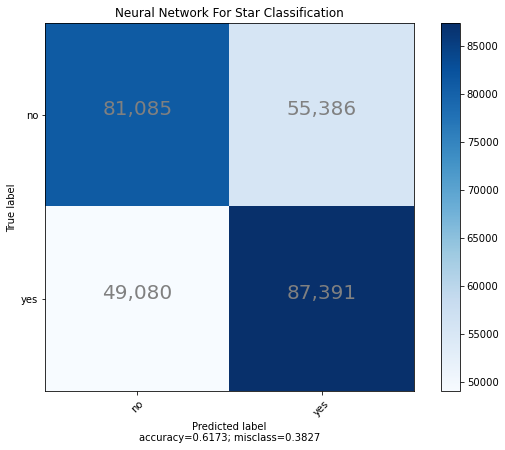

In [270]:
target_names = matrix_labels 
plot_confusion_matrix(NNtest,
                          target_names,
                          title='Neural Network For Star Classification',
                          cmap=None,
                          normalize=None)

In [366]:
print(recall_score(y_test_rus, y_predNN , average="macro"))

0.6172593444761159


In [371]:
recall_score(y_test_rus, y_predNN , average="macro")

In [268]:
# Fold improvment over chance (23% is better than LR 16% predictive improvement over guessing, but still not great)
recall_score(y_test_rus, y_predNN, average = 'macro')/(1/NNtest.shape[0])

1.2345186889522317

In [385]:
NNscore = 100*(recall_score(y_test_rus, y_predNN, average = 'macro')/(1/NNtest.shape[0])-1)

## Neural Network to model whether restaurant category words can predict most likely city associated with positive reviews

In [271]:
# Rebuild the dataset to contain cities as labels for reviews that are positive
df_food_states = df_food_v2.loc[df_food_v2['state_star'].str.contains('yes')].reset_index(drop=True)

In [272]:
vectorizertf_st = TfidfVectorizer(analyzer='word', min_df=50, max_features=50)
Xvectf_st = vectorizertf_st.fit_transform(df_food_states['food_comb'])
tf_df_st = pd.DataFrame(Xvectf_st.toarray(), columns=vectorizertf_st.get_feature_names())

In [273]:
df_vec_st = tf_df_st

In [274]:
# Xst = word vectors as features, yst =  as city labels
Xst = df_vec_st
yst = df_food_states['state']

In [284]:
le_train_st = LabelEncoder()
y_le_st = le_train.fit_transform(yst)

In [275]:
pca_st = PCA()
Xpca_st = pca_st.fit_transform(Xst)


Text(0.5, 1.0, 'PCA of word vector features from positve reviews')

/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


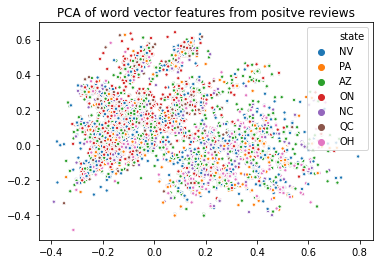

In [356]:
sns.scatterplot(Xpca_st[:, 0], Xpca_st[:, 1], hue = df_food_states['state'], s= 10)
plt.title('PCA of word vector features from positve reviews')

## PCA here has a similar clustering pattern, but hardly associates with any cities overall

In [277]:
# Checking for carefully if cities have difference in ratio of kmeans labels on the 2 PCA components
km_st = KMeans(n_clusters = 2)
km_st.fit_transform(Xpca_st)
labels_st = km_st.fit_predict(Xpca_st)

Text(0.5, 1.0, 'PCA of word vector features by kmeans labels')

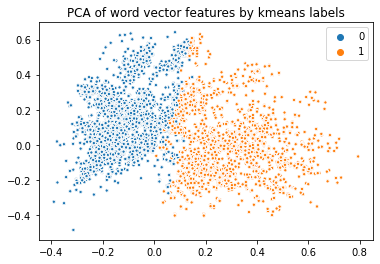

In [357]:
sns.scatterplot(Xpca_st[:, 0], Xpca_st[:, 1], hue = labels_st, s= 10)
plt.title('PCA of word vector features by kmeans labels')

The PCA labeled by kmeans labels on the first and second pca components show cluster separation by two halves

In [279]:
# Adding labels back to see if relationships exist with cities
df_food_state_labels = df_food_states.copy()
df_food_state_labels['labels'] = labels_st

In [280]:
labelcrosstab_st = pd.crosstab(df_food_state_labels['state'],df_food_state_labels['labels']).reset_index()

In [281]:
labelcrosstab_st['ratio'] = labelcrosstab_st[0]/(labelcrosstab_st[0]+labelcrosstab_st[1])

In [358]:
# Toronto (ON) and montreal seem to show some mild tendency to associate with cluster 1, but not by much
labelcrosstab_st

labels,state,0,1,ratio
0,AZ,328378,207238,0.613085
1,NC,77310,52869,0.593875
2,NV,405611,231560,0.636581
3,OH,55120,38883,0.586364
4,ON,178261,28053,0.864028
5,PA,52844,37283,0.586328
6,QC,45579,12344,0.786889


In [359]:
# For reverting encoded labels back to string labels
y_state_dict_st= pd.concat([pd.DataFrame(y_le_st), pd.DataFrame(yst)], axis = 1).groupby('state')[0].mean()

In [360]:
y_state_dict_swap_st = {value:key for key, value in y_state_dict_st.items()}

In [361]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(Xst, y_le_st, stratify = y_le_st, random_state = 42)

In [362]:
rus_st = RandomUnderSampler()
X_train_rus_st, y_train_rus_st = rus_st.fit_sample(X_train_st, y_train_st)
X_test_rus_st, y_test_rus_st = rus_st.fit_sample(X_test_st, y_test_st)


In [363]:
scaler_st = MinMaxScaler()
X_train_scaled_st = scaler_st.fit_transform(X_train_rus_st)
X_test_scaled_st = scaler_st.transform(X_test_rus_st)

In [364]:
y_train_dummies_st = pd.get_dummies(pd.Series(y_train_rus_st))
y_test_dummies_st = pd.get_dummies(y_test_rus_st)

In [365]:
model_st = Sequential()
model_st.add(Dense(1024, input_dim= X_train_scaled_st.shape[1], activation='relu'))
model_st.add(Dense(64, activation='relu'))
model_st.add(Dense(64, activation='relu'))
model_st.add(Dense(7, activation='softmax'))

In [294]:
model_st.compile(optimizer= 'adam', loss = 'categorical_crossentropy', metrics = [Recall()])
model_st.fit(X_train_scaled_st, y_train_dummies_st, batch_size=200, epochs=50, validation_data = (X_test_scaled_st, y_test_dummies_st))

Train on 304094 samples, validate on 101367 samples
Epoch 1/50
304094/304094 [==============================] - 4s 14us/sample - loss: 1.5741 - recall_2: 0.1403 - val_loss: 1.4522 - val_recall_2: 0.2228
Epoch 2/50
304094/304094 [==============================] - 4s 13us/sample - loss: 1.3824 - recall_2: 0.2603 - val_loss: 1.3536 - val_recall_2: 0.2781
Epoch 3/50
304094/304094 [==============================] - 4s 14us/sample - loss: 1.3175 - recall_2: 0.2938 - val_loss: 1.3046 - val_recall_2: 0.2970
Epoch 4/50
304094/304094 [==============================] - 4s 13us/sample - loss: 1.2859 - recall_2: 0.3068 - val_loss: 1.2870 - val_recall_2: 0.3168
Epoch 5/50
304094/304094 [==============================] - 4s 13us/sample - loss: 1.2670 - recall_2: 0.3144 - val_loss: 1.2746 - val_recall_2: 0.3180
Epoch 6/50
304094/304094 [==============================] - 4s 13us/sample - loss: 1.2531 - recall_2: 0.3190 - val_loss: 1.2558 - val_recall_2: 0.3170
Epoch 7/50
304094/304094 [================

In [300]:
y_predNN_st = model_st.predict_classes(X_test_scaled_st)


In [309]:
def plot_confusion_matrix_st(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=10)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=10)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [304]:
NNtest_st = confusion_matrix(y_test_rus_st, y_predNN_st, normalize = None)


In [305]:
matrix_labels_st = list(y_state_dict_swap_st.values())

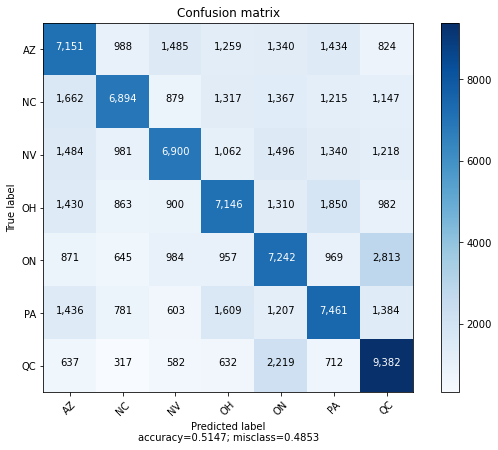

In [311]:
target_names_st = matrix_labels_st 
plot_confusion_matrix_st(NNtest_st,
                          target_names_st,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None)

In [367]:

NNscore_st = recall_score(y_test_rus_st, y_predNN_st, average = 'macro')
NNscore_st

0.5147237266566042

In [303]:
recall_score(y_test_rus_st, y_predNN_st, average = 'macro')/(1/NNtest_st.shape[0])

3.6030660865962294

This model gives about a 50% chance of predicting the correct state, which is about 3.6 times better than simply guessing.

In [390]:
model =  ['LR score', 'RF score', 'GB score', 'NN score']
score =  [LRscore,  RFscore,  GBscore, NNscore]

In [391]:
score_summary = pd.DataFrame()
score_summary['Model'] =model
score_summary['Score'] =score

# Conclusions

The overall goal of the project is to develop a tool to help potential restaurant owners to help predict the success of such a restaurant based on a list key words that would describe the restaurant food types, ethnicity, and planned venue type.

This involved two steps:

A. Build a  model that predicts restaurant popularity overall based on restaurant category words from ~100,000 
   reviews from a Yelp database across 7 metroplexes
B. Build a model that can predict which city a planned restaurant would be most popular in based on the assembly of category word associated with the restaurant

The best modeling platform from model A was further used to build model B

1. Restaurant category words showed some mild abilityt distiguish between US and Canadian restaurants, such as American. Although it is obvious that American restaurants are not popular in Canada, it shows that the feature importance does use that as a key feature, and likely arises from this difference

2. The Best model out of two Ensemble models and logistic regression, the Neural Network worked best. 



<BarContainer object of 4 artists>

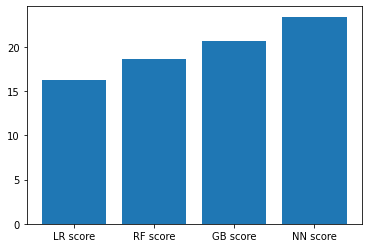

In [392]:
plt.bar(score_summary['Model'], score_summary['Score'])

3. Predicted popular restaurants was not very good based on selected word features alone. Earlier models did include states (dummified) as well as average income bracket per zip code, but those features did not help. In fact income as feature eliminated any predictive capacity.


4. Interestingly vecorized word features from positive reviews did have modest predictive power to classify which state they belonged to. This shows some promise in further optimizing this model by feature engineering and hypertuning.

# Future Directions

Prediction of best zip code

Improve category words for vectorization

Add demographic features (ethnicity distribution of population, aver age group, marital status)

Add restaurant density information by city or even by zipcode

Overlay traffic pattern info from latch data from US bureau of transportation (street level decisions)

Flip model to predict restaurant words best associated with positive review by region
